## Step 7: Run preranked GSEA with Ep300 knockout differential expression test results

We will now evaluate whether the RNA-seq results from the Ep300 knockout experiments show enrichment of the up- or down-signature epigenetic memory astrocyte gene signatures using preranked GSEA.

In [1]:
import os
os.chdir('..') # change working directory to 'EpiMemAstros' folder
import pandas as pd
from pathlib import Path
import numpy as np
import anndata as ad
from scipy import sparse
import gseapy as gp
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Arial'

We'll use the package GSEApy to run this testing. Below we'll make a few adjustments to the plotting function to present the enrichment score and nominal p-value. We do not make use of the FDR q-value because we are only testing for enrichment in a small number of very large gene sets.

The following code is adapted from the [GSEApy Github repository](https://github.com/zqfang/GSEApy).

In [2]:
from typing import Any, Dict, Iterable, List, Optional, Sequence, Tuple, Union
import matplotlib.transforms as transforms
from matplotlib.colors import Normalize

class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, vcenter=None, clip=False):
        self.vcenter = vcenter
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.vcenter, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y, left=-np.inf, right=np.inf))

    def inverse(self, value):
        y, x = [self.vmin, self.vcenter, self.vmax], [0, 0.5, 1]
        return np.interp(value, x, y, left=-np.inf, right=np.inf)

def GSEAplott(
    self,
    terms: Union[str, List[str]],
    colors: Optional[Union[str, List[str]]] = None,
    legend_kws: Optional[Dict[str, Any]] = None,
    figsize: Tuple[float, float] = (4, 5),
    show_ranking: bool = True,
    ofname: Optional[str] = None,
):
    """
    terms: str, list.  terms/pathways to show
    colors: str, list. list of colors for each term/pathway
    legend_kws: kwargs to pass to ax.legend. e.g. `loc`, `bbox_to_achor`.
    ofname: savefig
    """
    if self.module in ["ssgsea", "gsva"]:
        raise NotImplementedError("not for ssgsea")
    keys = list(self._results.keys())
    if len(keys) > 1:
        raise NotImplementedError("Multiple Dataset input No supported yet!")

    ranking = self.ranking if show_ranking else None
    if isinstance(terms, str):
        gsdict = self.results[terms]
        g = GSEAPlot(
            term=terms,
            tag=gsdict["hits"],
            rank_metric=ranking,
            runes=gsdict["RES"],
            #nes=None,
            es=gsdict["es"],
            pval=gsdict["pval"],
            #fdr=None,
            ofname=ofname,
            pheno_pos="Positive score",
            pheno_neg="Negative score",
            color=colors,
            figsize=figsize,
        )
        g.add_axes()
        return g.fig

class GSEAPlot(object):
    def __init__(
        self,
        term: str,
        tag: Sequence[int],
        runes: Sequence[float],
        es: float,
        #nes: float,
        pval: float,
        #fdr: float,
        rank_metric: Optional[Sequence[float]] = None,
        pheno_pos: str = "",
        pheno_neg: str = "",
        color: Optional[str] = None,
        figsize: Tuple[float, float] = (6, 5.5),
        cmap: str = "seismic",
        ofname: Optional[str] = None,
        ax: Optional[plt.Axes] = None,
        **kwargs,
    ):
        """
        :param term: gene_set name
        :param tag: hit indices of rank_metric.index presented in gene set S.
        :param runes: running enrichment scores.
        :param nes: Normalized enrichment scores.
        :param pval: nominal p-value.
        :param fdr: false discovery rate.
        :param rank_metric: pd.Series for rankings, rank_metric.values.
        :param pheno_pos: phenotype label, positive correlated.
        :param pheno_neg: phenotype label, negative correlated.
        :param figsize: matplotlib figsize.
        :param ofname: output file name. If None, don't save figure.
        :param ax: matplotlib axes. Default: None.
        """
        # dataFrame of ranked matrix scores
        self.color = "#88C544" if color is None else color
        self._x = np.arange(len(runes))
        self.rankings = None
        self._zero_score_ind = None
        self._z_score_label = None
        if rank_metric is not None:
            self.rankings = np.asarray(rank_metric)
            self._zero_score_ind = np.abs(self.rankings).argmin()
            self._z_score_label = "Zero score at " + str(self._zero_score_ind)

        self.RES = np.asarray(runes)

        self.figsize = figsize
        self.term = term
        self.cmap = cmap
        self.ofname = ofname

        self._pos_label = pheno_pos
        self._neg_label = pheno_neg
        self._hit_indices = tag
        self.module = "tmp" if ofname is None else ofname.split(".")[-2]
        
        self._es_label = "ES: " + "{:.3f}".format(float(es))

        if pval < 0.001:
            self._pval_label = "p < 0.001"
        elif pval == 1:
            self._pval_label = "p = " + "{:.2f}".format(float(pval))
        else:
            self._pval_label = "p = " + "{:.3f}".format(float(pval))

        # output truetype
        plt.rcParams.update({"pdf.fonttype": 42, "ps.fonttype": 42})
        # in most case, we will have many plots, so do not display plots
        # It's also usefull to run this script on command line.
        
        self.fig = plt.figure(figsize=self.figsize, facecolor="white")
        self.fig.suptitle(self.term, fontsize=16, wrap=True, fontweight="bold")

    def axes_rank(self, rect):
        """
        rect : sequence of float
               The dimensions [left, bottom, width, height] of the new axes. All
               quantities are in fractions of figure width and height.
        """
        # Ranked Metric Scores Plot
        ax1 = self.fig.add_axes(rect)
        
        ax1.fill_between(self._x, y1=self.rankings, y2=0, color="#C9D3DB")
        ax1.set_ylabel("Ranked metric", fontsize=16)

        ax1.text(
            0.05,
            0.9,
            self._pos_label,
            color="red",
            horizontalalignment="left",
            verticalalignment="top",
            transform=ax1.transAxes,
        )
        ax1.text(
            0.95,
            0.05,
            self._neg_label,
            color="Blue",
            horizontalalignment="right",
            verticalalignment="bottom",
            transform=ax1.transAxes,
        )
        # the x coords of this transformation are data, and the y coord are axes
        trans1 = transforms.blended_transform_factory(ax1.transData, ax1.transAxes)
        ax1.vlines(
            self._zero_score_ind,
            0,
            1,
            linewidth=0.5,
            transform=trans1,
            linestyles="--",
            color="grey",
        )

        hap = self._zero_score_ind / max(self._x)
        if hap < 0.25:
            ha = "left"
        elif hap > 0.75:
            ha = "right"
        else:
            ha = "center"
        ax1.text(
            hap,
            0.5,
            self._z_score_label,
            horizontalalignment=ha,
            verticalalignment="center",
            transform=ax1.transAxes,
            fontsize=10,
        )
        ax1.set_xlabel("Gene Rank", fontsize=16)
        ax1.spines["top"].set_visible(False)
        ax1.tick_params(
            axis="both", which="both", top=False, right=False, left=False, labelsize=14
        )
        ax1.locator_params(axis="y", nbins=5)
        ax1.yaxis.set_major_formatter(
            plt.FuncFormatter(lambda tick_loc, tick_num: "{:.1f}".format(tick_loc))
        )

    def axes_hits(self, rect, bottom: bool = False):
        """
        rect : sequence of float
               The dimensions [left, bottom, width, height] of the new axes. All
               quantities are in fractions of figure width and height.
        """
        # gene hits
        ax2 = self.fig.add_axes(rect)
        # the x coords of this transformation are data, and the y coord are axes
        trans2 = transforms.blended_transform_factory(ax2.transData, ax2.transAxes)
        # to make axes shared with same x cooridincates, make the vlines same ranges to x
        ax2.vlines(
            [self._x[0], self._x[-1]],
            0,
            1,
            linewidth=0.5,
            transform=trans2,
            color="white",
            alpha=0,
        )  # alpha 0 to transparency
        # add hits line
        ax2.vlines(
            self._hit_indices, 0, 1, linewidth=0.5, transform=trans2, color="black"
        )

        ax2.tick_params(
            axis="both",
            which="both",
            bottom=bottom,
            top=False,
            right=False,
            left=False,
            labelbottom=bottom,
            labelleft=False,
        )
        if bottom:
            ax2.set_xlabel("Gene Rank", fontsize=16)
            ax2.spines["bottom"].set_visible(True)

    def axes_cmap(self, rect):
        """
        rect : sequence of float
               The dimensions [left, bottom, width, height] of the new axes. All
               quantities are in fractions of figure width and height.
        """
        # center color map at midpoint = 0
        mat = self.rankings
        if self.rankings is None:
            mat = self.RES
        vmin = np.percentile(mat.min(), 2)
        vmax = np.percentile(mat.max(), 98)
        midnorm = MidpointNormalize(vmin=vmin, vcenter=0, vmax=vmax)
        # colormap
        ax3 = self.fig.add_axes(rect)
        ax3.pcolormesh(
            mat[np.newaxis, :],
            rasterized=True,
            norm=midnorm,
            cmap=self.cmap,
        )  # cm.coolwarm
        ax3.spines["bottom"].set_visible(False)
        ax3.tick_params(
            axis="both",
            which="both",
            bottom=False,
            top=False,
            right=False,
            left=False,
            labelbottom=False,
            labelleft=False,
        )

    def axes_stat(self, rect):
        """
        rect : sequence of float
               The dimensions [left, bottom, width, height] of the new axes. All
               quantities are in fractions of figure width and height.
        """
        # Enrichment score plot

        ax4 = self.fig.add_axes(rect)
        ax4.plot(self._x, self.RES, linewidth=4, color=self.color)
        #ax4.text(0.1, 0.1, self._fdr_label, transform=ax4.transAxes, fontsize=14)
        ax4.text(1, 0.8, self._pval_label, transform=ax4.transAxes, fontsize=14, horizontalalignment='right')
        ax4.text(1, 0.9, self._es_label, transform=ax4.transAxes, fontsize=14, horizontalalignment='right')

        # the y coords of this transformation are data, and the x coord are axes
        trans4 = transforms.blended_transform_factory(ax4.transAxes, ax4.transData)
        ax4.hlines(0, 0, 1, linewidth=1, transform=trans4, color="grey")
        ax4.set_ylabel("Enrichment Score", fontsize=16)
        # ax4.set_xlim(min(self._x), max(self._x))
        ax4.tick_params(
            axis="both",
            which="both",
            bottom=False,
            top=False,
            right=False,
            labelbottom=False,
            labelsize=14,
        )
        ax4.locator_params(axis="y", nbins=5)
        ax4.yaxis.set_major_formatter(
            plt.FuncFormatter(lambda tick_loc, tick_num: "{:.1f}".format(tick_loc))
        )

        self.ax = ax4
    
    def add_axes(self):
            """
            Please check matplotlib docs about how to `add_axes` to figure.
    
            Here is a more flexible way to create a new gseaplot.
            For example, don't show ranking and merge hits and colormap together
            just used:
    
                self.axes_stat([0.1,0.2,0.8,0.8]) # axes_stat should be called first
                self.axes_cmap([0.1,0.1,0.8,0.1])
                self.axes_hits([0.1,0.1,0.8,0.1])
    
            """
    
            left = 0.1
            width = 0.8
            bottom = 0.1
            height = 0
    
            stat_height_ratio = 0.4
            hits_height_ratio = 0.05
            cmap_height_ratio = 0.05
            rank_height_ratio = 0.3
            ## make stat /hits height ratio const
            if self.rankings is None:
                rank_height_ratio = 0
                cmap_height_ratio = 0
            base = 0.8 / (
                stat_height_ratio
                + hits_height_ratio
                + cmap_height_ratio
                + rank_height_ratio
            )
            if self.rankings is not None:
                height = rank_height_ratio * base
                self.axes_rank([left, bottom, width, height])
                bottom += height
                height = cmap_height_ratio * base
                self.axes_cmap([left, bottom, width, height])
                bottom += height
            height = hits_height_ratio * base
            self.axes_hits(
                [left, bottom, width, height], bottom=False if bottom > 0.1 else True
            )
            bottom += height
            height = stat_height_ratio * base
            self.axes_stat([left, bottom, width, height])

We'll first read in the Up- and Down-Signature gene sets from Supplementary Table 3 as we've done in the prior steps.

In [3]:
signature = pd.read_excel('inputs/zenodo/supplementary_tables/41586_2024_7187_MOESM4_ESM.xlsx')

up_signature = np.sort(signature[(signature.log2FoldChange > 0)].gene.values)
down_signature = np.sort(signature[(signature.log2FoldChange < 0)].gene.values)

Next we'll create a list with these gene sets.

In [4]:
gene_sets = {'Up-Signature':up_signature, 'Down-Signature':down_signature}

Now, we read in the Ep300 differential expression test results from Supplementary Table 4.

In [5]:
ep300_ko = pd.read_excel('inputs/zenodo/supplementary_tables/41586_2024_7187_MOESM5_ESM.xlsx')

The methods section in the original manuscript does not make clear whether GSEA or GSEA Preranked was performed. Here we could only perform GSEA preranked because the original RNA-seq data for this experiment was not publicly available at the time of writing.

We apply GSEA preranked using a common ranking method: ranking genes by the product of their log2-fold change value and -log10(adjusted p-value). First we calculate this ranking score.

In [6]:
ep300_ko['rank'] = -1*np.log10(ep300_ko['padj'])*ep300_ko['log2FoldChange']
ep300_ko = ep300_ko.sort_values('rank', ascending=False)
ep300_ko_rnk = ep300_ko[['Gene', 'rank']]
ep300_ko_rnk = ep300_ko_rnk.set_index('Gene')
ep300_ko_rnk.index = ep300_ko_rnk.index.astype(str)

ep300_ko_rnk

,rank
Gene,
Nr4a3,5.604073
Gm29408,4.219498
Hif3a,4.172823
Cfap54,3.826766
Extl1,3.681240
...,...
Ints6,-1.407932
Lactb2,-2.432747
Tln2,-3.441600


Two genes appear to have more than one entry in Supplementary Table 4, but these aren't simple duplications – the p-values and/or log2-fold changes between entries differ. One of these genes also appears to have been accidentally converted to date/time format, likely due to Microsoft Excel's unfortunate format conversion settings. To be careful, we exclude these duplicates from the ranked list.

In [7]:
ep300_ko[ep300_ko.Gene.duplicated(keep = False)]

,Gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Unnamed: 7,Unnamed: 8,rank
467,Zeb2,634.118684,0.411922,0.209675,1.964579,0.049463,0.647030,NaN,NaN,0.077884
4139,2022-03-02 00:00:00,130.328579,0.262539,0.424404,0.618607,0.536175,0.960163,NaN,NaN,0.004635
1358,2022-03-02 00:00:00,313.528567,-0.029192,0.173496,-0.168257,0.866381,0.999720,NaN,NaN,-0.000004
1024,Zeb2,381.574287,-0.394161,0.200455,-1.966338,0.049260,0.647030,NaN,NaN,-0.074526


In [8]:
ep300_ko_rnk = ep300_ko_rnk[~ep300_ko_rnk.index.duplicated(keep=False)]

We now run the GSEA and examine the results:

In [9]:
res = gp.prerank(rnk = ep300_ko_rnk, gene_sets=gene_sets, max_size = 2000, permutation_number = 1000, verbose = True, seed = 6)
res.res2d

2025-01-03 02:30:55,164 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-01-03 02:30:55,164 [INFO] Parsing data files for GSEA.............................
2025-01-03 02:30:55,166 [INFO] 0000 gene_sets have been filtered out when max_size=2000 and min_size=15
2025-01-03 02:30:55,167 [INFO] 0002 gene_sets used for further statistical testing.....
2025-01-03 02:30:55,167 [INFO] Start to run GSEA...Might take a while..................
2025-01-03 02:30:55,803 [INFO] Congratulations. GSEApy runs successfully................



,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,Up-Signature,0.668466,1.479892,0.0,0.0,0.0,101/825,5.65%,Nr4a3;Gm29408;Ppp1r12b;Gm12840;Olfr1033;Crispl...
1,prerank,Down-Signature,-0.371151,-0.945906,0.625,0.625,0.666667,146/944,12.12%,Ak4;Ttyh2;Spp1;H2aw;Fez1;Wdr75;Sat1;Ndp;Efhd1;...


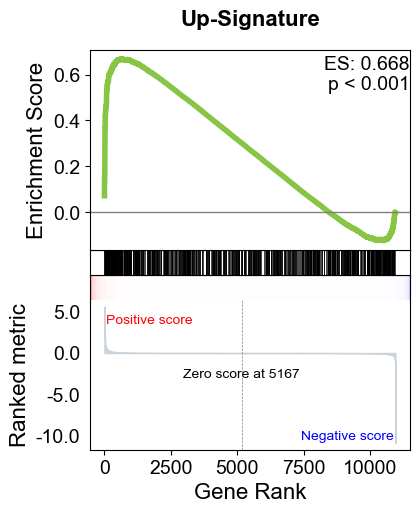

In [10]:
ax = GSEAplott(res, terms = res.res2d.Term[0])
plt.savefig('outputs/figures/figure2c_upsignature.svg', format='svg', dpi=1200,bbox_inches = 'tight')

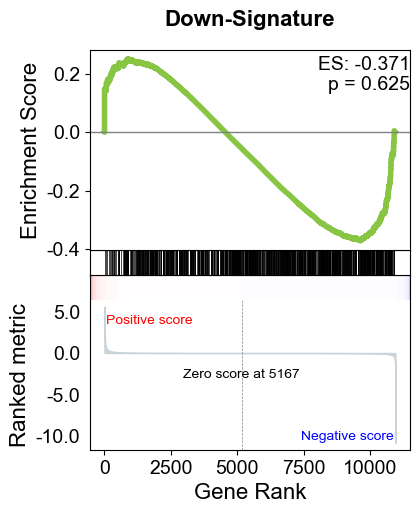

In [11]:
ax = GSEAplott(res, terms = res.res2d.Term[1])
plt.savefig('outputs/figures/figure2c_downsignature.svg', format='svg', dpi=1200,bbox_inches = 'tight')

We'll repeat this for the NOD EAE experiment data from Supplementary Table 8:

In [12]:
nod_ep300_ko = pd.read_excel('inputs/zenodo/supplementary_tables/41586_2024_7187_MOESM9_ESM.xlsx', 
                             sheet_name = 'p300 vs Scramble')
nod_ep300_ko['rank'] = -1*np.log10(nod_ep300_ko['padj'])*nod_ep300_ko['log2FoldChange']
nod_ep300_ko = nod_ep300_ko.sort_values('rank', ascending=False)
nod_ep300_ko_rnk = nod_ep300_ko[['Gene', 'rank']]
nod_ep300_ko_rnk = nod_ep300_ko_rnk.set_index('Gene')
nod_ep300_ko_rnk.index = nod_ep300_ko_rnk.index.astype(str)

In [13]:
nod_ep300_ko_rnk

,rank
Gene,
Gm25735,29.401022
Gm48313,19.458776
Gm19220,15.564153
Gm37357,15.323550
Gm27826,15.276905
...,...
Ugt8a,-6.894479
Arc,-10.516701
Gm4366,-12.174471


In [14]:
nod_res = gp.prerank(rnk = nod_ep300_ko_rnk, gene_sets=gene_sets, max_size = 2000, permutation_number = 1000, verbose = True, seed = 6)
nod_res.res2d

2025-01-03 02:30:58,626 [WARNING] Duplicated values found in preranked stats: 0.17% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-01-03 02:30:58,627 [INFO] Parsing data files for GSEA.............................
2025-01-03 02:30:58,629 [INFO] 0000 gene_sets have been filtered out when max_size=2000 and min_size=15
2025-01-03 02:30:58,630 [INFO] 0002 gene_sets used for further statistical testing.....
2025-01-03 02:30:58,630 [INFO] Start to run GSEA...Might take a while..................
2025-01-03 02:30:59,357 [INFO] Congratulations. GSEApy runs successfully................



,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,Up-Signature,-0.462473,-1.0,1.0,0.0,NaN,154/962,10.79%,Arc;Rasl12;Dnajb1;Adamts1;Clec5a;Cmtm6;Ermn;St...
1,prerank,Down-Signature,0.369539,0.642624,1.0,1.0,1.0,133/967,16.68%,Gm42785;Cacng4;Kcnj15;Adgra1;Rab34;Adgrl3;Gm48...


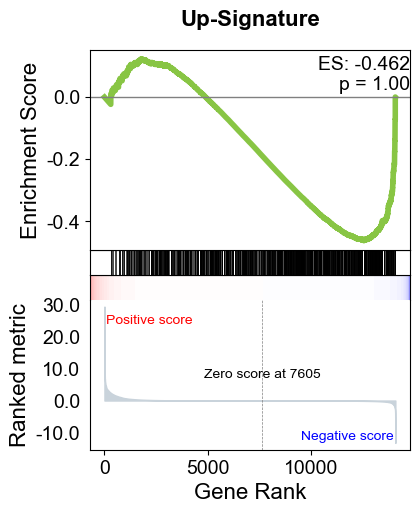

In [15]:
ax = GSEAplott(nod_res, terms = nod_res.res2d.Term[0])
plt.savefig('outputs/figures/figure2f_upsignature.svg', format='svg', dpi=1200,bbox_inches = 'tight')

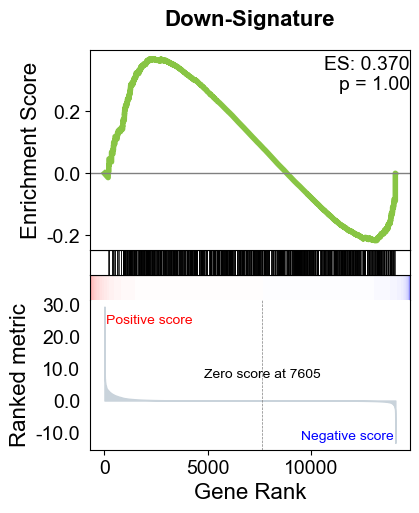

In [16]:
ax = GSEAplott(nod_res, terms = nod_res.res2d.Term[1])
plt.savefig('outputs/figures/figure2f_downsignature.svg', format='svg', dpi=1200,bbox_inches = 'tight')

We note several discrepancies from the findings reported by Lee et al:

1. The Ep300 knockout in EAE appears to have had an increase (rather than a decrease) in the Up-signature gene set when evaluated by pre-ranked GSEA.
2. The Ep300 knockout in EAE appears to have resulted in no significant difference (rather than a decrease) in the Up-signature gene set when evaluated by pre-ranked GSEA.
3. While Lee et al's Supplementary Tables 4 and 8 contain 825 and 962 Up-Signature genes with differential expression statistics, respectively, the GSEA plots in Lee et al's Figure 2D and Extended Data Figure 6H appear to show far fewer genes.